In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=fada546bb57d4fec283d3850bc55102ef73656b7bc683b97ff115dcf1eee883b
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
# Necessary imports
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.window import *
import matplotlib.pyplot as plt
from sklearn.metrics import *
from pyspark.ml.feature import *
from pyspark.ml.regression import *
from pyspark.ml import Pipeline

In [ ]:
spark = SparkSession.builder.appName("BTC_EOD_Pred").getOrCreate()

In [ ]:
# Ensure this file is present in the current working directory
df = pd.read_csv("""btc_price_history_daily.csv""")

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df_s = spark.createDataFrame(df)

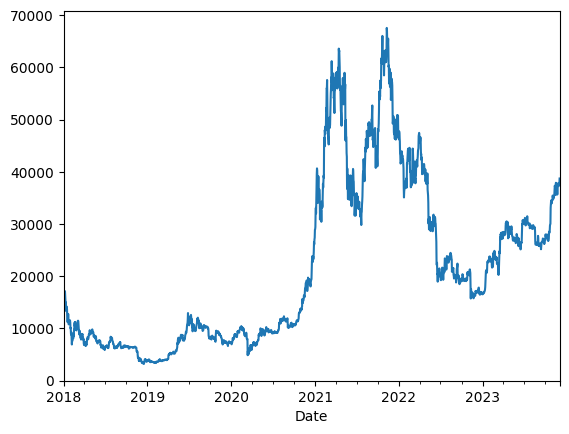

In [ ]:
df_plot = df.set_index('Date')
df_plot['Price'].plot()
plt.show()

In [ ]:
# Creating our own train_test_split function since this is a time series data and we can't use random split
def train_cv_test(df, train_rows, cv_rows):
  df_train = df.iloc[:train_rows,:]
  df_cv = df.iloc[train_rows:(train_rows+cv_rows),:]
  df_test = df.iloc[(train_rows+cv_rows):,:]
  return df_train, df_cv, df_test

In [ ]:
# Splitting the whole dataset to train, validation and testing dataset
df_train, df_cv, df_test = train_cv_test(df, 1500, 300)
df_train_s = spark.createDataFrame(df_train)
df_cv_s = spark.createDataFrame(df_cv)
df_test_s = spark.createDataFrame(df_test)

In [ ]:
# Creating our metrics function that calculates the MAPE values for train, cv and test datasets
def metrics(df_train, df_cv, df_test, actuals_col, preds_col):
  df_train = df_train.dropna()
  df_cv = df_cv.dropna()
  df_test = df_test.dropna()

  train_mape = mean_absolute_percentage_error(df_train[actuals_col], df_train[preds_col])
  cv_mape = mean_absolute_percentage_error(df_cv[actuals_col], df_cv[preds_col])
  test_mape = mean_absolute_percentage_error(df_test[actuals_col], df_test[preds_col])
  print(f'Train MAPE = {round(train_mape*100,2)}%')
  print(f'CV MAPE = {round(cv_mape*100,2)}%')
  print(f'Test MAPE = {round(test_mape*100,2)}%')
  return train_mape, cv_mape, test_mape

<h1><strong>Rolling Window</strong></h1>
Baseline model which we target to beat

In [ ]:
# Function that calculates the rolling means of the prices for a given number of days
def rolling_mean(df, days = 7):
  rolling_window = Window.orderBy("Date").rowsBetween(-(days), -1)
  df_new = df.withColumn(
      f"rolling_mean_{days}",
      f.avg("Price").over(rolling_window)
  )
  return df_new

In [ ]:
days = 7
df_rolling_train = rolling_mean(df_train_s, days).withColumnRenamed(f"rolling_mean_{days}", "rolling_mean")
df_rolling_cv = rolling_mean(df_cv_s, days).withColumnRenamed(f"rolling_mean_{days}", "rolling_mean")
df_rolling_test = rolling_mean(df_test_s, days).withColumnRenamed(f"rolling_mean_{days}", "rolling_mean")

In [ ]:
df_rolling_train_pd = df_rolling_train.toPandas()
df_rolling_cv_pd = df_rolling_cv.toPandas()
df_rolling_test_pd = df_rolling_test.toPandas()

In [ ]:
train_mape, cv_mape, test_mape = metrics(df_rolling_train_pd, df_rolling_cv_pd, df_rolling_test_pd, 'Price', 'rolling_mean')

Train MAPE = 5.01%
CV MAPE = 4.21%
Test MAPE = 2.75%


<h1><strong>Regression Model</strong></h1>

In [ ]:
# Function that calculates the lagged features of the prices for a given number of days
def lag_feature(df, lag_days):
  window_spec = Window.orderBy("Date")
  df_new = df.withColumn(f"Price_lag_{lag_days}", f.lag("Price", lag_days).over(window_spec))
  return df_new

In [ ]:
# Function that combines all the feature engineering done so far

def gbt_feature_eng(df):

  # Extracting day, month, week, and year
  df_new = df.withColumn("day", f.dayofmonth("Date")) \
              .withColumn("month", f.month("Date")) \
              .withColumn("week", f.weekofyear("Date")) \
              .withColumn("year", f.year("Date"))

  days_list = [1,2,3,7,14,30,45,60]
  for days in days_list:

    # Creating rolling mean columns
    df_new = rolling_mean(df_new, days)

    # Creating lagged columns
    df_new = lag_feature(df_new, days)

  return df_new

In [ ]:
# Our final model variables
input_cols = ['day',
 'month',
 'week',
 'year',
 'rolling_mean_1',
 'Price_lag_1',
 'rolling_mean_2',
 'Price_lag_2',
 'rolling_mean_3',
 'Price_lag_3',
 'rolling_mean_7',
 'Price_lag_7',
 'rolling_mean_14',
 'Price_lag_14',
 'rolling_mean_30',
 'Price_lag_30',
 'rolling_mean_45',
 'Price_lag_45',
 'rolling_mean_60',
 'Price_lag_60']

In [ ]:
# PErforming feature engineering on our input dataset
df_gbt_train = gbt_feature_eng(df_train_s)
df_gbt_cv = gbt_feature_eng(df_cv_s)
df_gbt_test = gbt_feature_eng(df_test_s)

# Imputing the null values
imputer = Imputer(strategy="mean", missingValue = 0.0, inputCols=input_cols, outputCols=input_cols)

# Assembling all the features into a vector
assembler = VectorAssembler(inputCols=input_cols, outputCol="features", handleInvalid="skip")

# Building our model. Tried Random Forest and Gradient Boosting as well.
# model = RandomForestRegressor(maxDepth = 5, minInstancesPerNode = 4, featuresCol="features", labelCol="Price")
# model = GBTRegressor(maxDepth = 5, minInstancesPerNode = 4, featuresCol="features", labelCol="Price")
model = LinearRegression(maxIter=200, elasticNetParam=1, featuresCol = 'features', labelCol = 'Price')

# Combining all the stages into a pipeline
pipeline = Pipeline(stages = [imputer, assembler, model])

# Fitting our model pipeline on the train data
pipeline_model = pipeline.fit(df_gbt_train)

# Getting the predictions from our pipeline
df_gbt_train = pipeline_model.transform(df_gbt_train)
df_gbt_cv = pipeline_model.transform(df_gbt_cv)
df_gbt_test = pipeline_model.transform(df_gbt_test)

In [ ]:
# Our final predictions are present in the 'prediction' column
df_gbt_train.show()

+------+-------------------+--------+---+-----+----+----+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+--------------------+------------------+
|Ticker|               Date|   Price|day|month|week|year|   rolling_mean_1|      Price_lag_1|    rolling_mean_2|      Price_lag_2|    rolling_mean_3|       Price_lag_3|    rolling_mean_7|      Price_lag_7|   rolling_mean_14|      Price_lag_14|   rolling_mean_30|      Price_lag_30|   rolling_mean_45|     Price_lag_45|   rolling_mean_60|      Price_lag_60|            features|        prediction|
+------+-------------------+--------+---+-----+----+----+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-

In [ ]:
df_gbt_train_pd = df_gbt_train.select('Date','Price','prediction').toPandas()
df_gbt_cv_pd = df_gbt_cv.select('Date','Price','prediction').toPandas()
df_gbt_test_pd = df_gbt_test.select('Date','Price','prediction').toPandas()

In [ ]:
metrics(df_gbt_train_pd, df_gbt_cv_pd, df_gbt_test_pd, 'Price', 'prediction')

Train MAPE = 2.97%
CV MAPE = 3.15%
Test MAPE = 1.83%


(0.029680392045936595, 0.03148342731933034, 0.018257670493700563)

In [ ]:
# Saving our model
pipeline_model.save("btc_model.pkl")

In [ ]:
# Creating a zip file of our model
!zip -r '/content/model.zip' '/content/btc_model.pkl'

  adding: content/btc_model.pkl/ (stored 0%)
  adding: content/btc_model.pkl/metadata/ (stored 0%)
  adding: content/btc_model.pkl/metadata/.part-00000.crc (stored 0%)
  adding: content/btc_model.pkl/metadata/._SUCCESS.crc (stored 0%)
  adding: content/btc_model.pkl/metadata/part-00000 (deflated 24%)
  adding: content/btc_model.pkl/metadata/_SUCCESS (stored 0%)
  adding: content/btc_model.pkl/stages/ (stored 0%)
  adding: content/btc_model.pkl/stages/0_Imputer_754f79066e66/ (stored 0%)
  adding: content/btc_model.pkl/stages/0_Imputer_754f79066e66/data/ (stored 0%)
  adding: content/btc_model.pkl/stages/0_Imputer_754f79066e66/data/part-00000-ffee3d84-025f-4ac3-abb1-bcabad34780d-c000.snappy.parquet (deflated 73%)
  adding: content/btc_model.pkl/stages/0_Imputer_754f79066e66/data/._SUCCESS.crc (stored 0%)
  adding: content/btc_model.pkl/stages/0_Imputer_754f79066e66/data/_SUCCESS (stored 0%)
  adding: content/btc_model.pkl/stages/0_Imputer_754f79066e66/data/.part-00000-ffee3d84-025f-4ac3-